# Creación de un modelo desde cero con aumento de imágenes

## Librerías necesarias

In [36]:
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

## Variables globales del sistema

In [ ]:
original_dir = pathlib.Path("DatasetOriginal/Image Data Base")
new_base_dir = pathlib.Path("ExpandedDataset/")
content = os.listdir(original_dir)
BATCH_SIZE = 64
size_x = 256
size_y = 256

## Función para contar imágenes por categorías

In [ ]:
def categories_counter():
    counter_more200 = 0
    counter_less200 = 0
    categories = {}
    for category in content:
        counter = 0
        for path in pathlib.Path(original_dir / category).iterdir():   
            counter += 1
        if counter < 200:
            counter_less200 += 1
            categories.update({str(category):counter})
            
        else:
            counter_more200 += 1
    print("Hay "+ str(counter_more200) + " categorias con más de 200 ejemplos")
    print("Hay "+ str(counter_less200) + " categorias con menos de 200 ejemplos")
    return categories
        
categories = categories_counter()

In [ ]:
print(categories)

## Creación de un conjunto de datos nuevo con nombres apropiados

In [ ]:
def prepare_dataset(max_data):
    for category in content:
        fnames = []
        count = 1
        for path in (original_dir / category).iterdir():
            fnames.append(os.path.basename(path))
            count += 1
        dir = new_base_dir / category
        os.makedirs(dir)
        count = 0
        while count < len(fnames) and count < max_data:
            file_name = str(count) + '.jpg'
            try:
                shutil.copyfile(src=original_dir / category / fnames[count], dst=dir / file_name)
                count += 1
            except:
                print("error")
                
prepare_dataset(200)

## Creación de imágenes aumentadas en relación a las existentes 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=45,    
        width_shift_range=0.2,   
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', cval=125)


def image_creator(image, category):
    i = 0
    for batch in datagen.flow(image, batch_size=1,
                              save_to_dir='ExpandedDataset/' + category,
                              save_prefix='aug',
                              save_format='jpg'):
        i += 1
        if i > 0:
            break


def dataset_augment(categories, objective_number):
    for category in categories:
        category_name = str(category)
        category_counter = categories[category_name]
        image_counter = category_counter
        i = 0
        while image_counter < objective_number:
            if i >= category_counter:
                i = 0
            print('ExpandedDataset/' + category_name + '/' + str(i) + '.jpg')
            image = io.imread('ExpandedDataset/' + category_name + '/' + str(i) + '.jpg')
            image = image.reshape((1,) + image.shape)  # Array with shape (1, 256, 256, 3)
            image_creator(image, category_name)
            i += 1
            image_counter += 1
            
    
dataset_augment(categories, 200)

In [ ]:
def categories_counter():
    counter_more200 = 0
    counter_less200 = 0
    categories = {}
    for category in content:
        counter = 0
        for path in pathlib.Path(new_base_dir / category).iterdir():
            counter += 1
        if counter < 200:
            counter_less200 += 1
            categories.update({str(category): counter})
        else:
            counter_more200 += 1
    print("Hay " + str(counter_more200) + " categorias con más de 200 ejemplos")
    print("Hay " + str(counter_less200) + " categorias con menos de 200 ejemplos")
    return categories

categories = categories_counter()

## Creación de subcarpetas a partir del nuevo dataset creado

In [ ]:
original_dir = pathlib.Path("ExpandedDataset/")
new_base_dir = pathlib.Path("ExpandedDataset_organized/")

def make_subsets(proportion, max_data):
    for category in content:
        fnames = []
        count = 1
        for path in (original_dir / category).iterdir():
            fnames.append(os.path.basename(path))
            count += 1
        leftover = count % 10
        data = count - leftover
        data = min(data, max_data)
        primero = int(data * proportion[0])
        segundo = int(data * proportion[1]) + primero
        tercero = int(data * proportion[2]) + segundo
        train = fnames[0:primero]
        validation = fnames[primero:segundo]
        test = fnames[segundo:tercero]
        if data < 200 and leftover > 0:
            train.extend(fnames[tercero:count - 1])
        classification = {"train": train, "validation": validation, "test": test}
        for subset in ["train", "validation", "test"]:
            dir = new_base_dir / subset / category
            os.makedirs(dir)
            count = 1
            for fname in classification[subset]:
                file = str(count) + '.jpg'
                try:
                    shutil.copyfile(src=original_dir / category / fname, dst=dir / file)
                    count += 1
                except:
                    print("error")
                    
                    
proportion = [0.8, 0.1, 0.1] #Para dividir los datos en conjuntos de estas proporciones
make_subsets(proportion, 200)

## Creación de los datasets específicos a partir de las carpetas 

In [ ]:
original_dir = pathlib.Path("ExpandedDataset/")
new_base_dir = pathlib.Path("ExpandedDataset_organized/")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(size_x, size_y),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

## Comprobación de que está todo en orden y muestreo

In [ ]:
 for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

In [ ]:
plt.figure(figsize=(13, 13))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(2):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        arr = labels[i].numpy()
        tuple = np.where(arr == 1)
        plt.title(class_names[tuple[0][0]])
        plt.axis("off")

## Modelo creado desde cero

In [ ]:
inputs = keras.Input(shape=(size_x, size_y, 3)) 
x = layers.Rescaling(1./255)(inputs) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(58, activation="softmax")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)

model1.summary()

## Entrenamiento y guardado de resultados del modelo cero

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="model1/best_version",
 save_best_only=True,
 monitor="val_loss")
]

In [ ]:
model1.compile(loss="categorical_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

In [ ]:
history = model1.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

In [ ]:
model1.save('model1/model')

In [ ]:
np.save('model1/history.npy',history.history)

## Análisis de resultados

In [ ]:
my_model0 = load_model('model0/model')
my_model1 = load_model('model1/model')

In [ ]:
my_history0=np.load('model0/history.npy',allow_pickle='TRUE').item()
my_history1=np.load('model1/history.npy',allow_pickle='TRUE').item()

In [ ]:
loss_0 = my_history0["loss"]
val_loss_0 = my_history0["val_loss"]
loss_1 = my_history1["loss"]
val_loss_1 = my_history1["val_loss"]
epochs = range(1, len(loss_0) + 1)

plt.plot(epochs, loss_0, "b.", label="Training loss original")
plt.plot(epochs, loss_1, "r.", label="Training loss new")
plt.plot(epochs, val_loss_0, "b", label="Validation loss original")
plt.plot(epochs, val_loss_1, "r", label="Validation loss new")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc_0 = my_history0["accuracy"]
val_acc_0 = my_history0["val_accuracy"]
acc_1 = my_history1["accuracy"]
val_acc_1 = my_history1["val_accuracy"]
epochs = range(1, len(loss_0) + 1)

plt.plot(epochs, acc_0, "b.", label="Training accuracy original")
plt.plot(epochs, acc_1, "r.", label="Training accuracy new")
plt.plot(epochs, val_acc_0, "b", label="Validation accuracy original")
plt.plot(epochs, val_acc_1, "r", label="Validation accuracy new")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc = my_history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



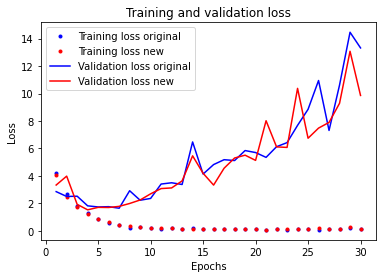

In [44]:
loss_0 = my_history0["loss"]
val_loss_0 = my_history0["val_loss"]
loss_1 = my_history1["loss"]
val_loss_1 = my_history1["val_loss"]
epochs = range(1, len(loss_0) + 1)

plt.plot(epochs, loss_0, "b.", label="Training loss original")
plt.plot(epochs, loss_1, "r.", label="Training loss new")
plt.plot(epochs, val_loss_0, "b", label="Validation loss original")
plt.plot(epochs, val_loss_1, "r", label="Validation loss new")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

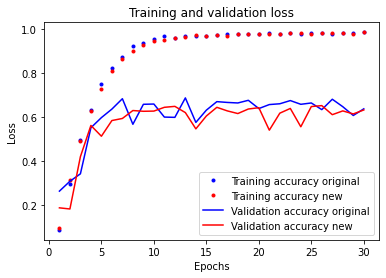

In [45]:
plt.clf()
acc_0 = my_history0["accuracy"]
val_acc_0 = my_history0["val_accuracy"]
acc_1 = my_history1["accuracy"]
val_acc_1 = my_history1["val_accuracy"]
epochs = range(1, len(loss_0) + 1)

plt.plot(epochs, acc_0, "b.", label="Training accuracy original")
plt.plot(epochs, acc_1, "r.", label="Training accuracy new")
plt.plot(epochs, val_acc_0, "b", label="Validation accuracy original")
plt.plot(epochs, val_acc_1, "r", label="Validation accuracy new")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

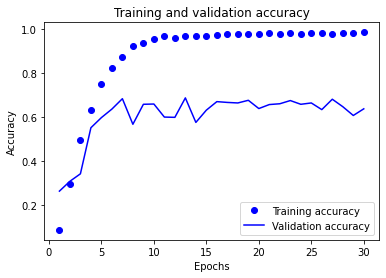

In [35]:
plt.clf()
acc = my_history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [36]:
model = keras.models.load_model('model0/model')
results= model.evaluate(test_dataset)
results

13/13 [==============================] - 4s 238ms/step - loss: 11.7977 - accuracy: 0.6687


[11.797684669494629, 0.6686967015266418]

In [37]:
model = keras.models.load_model('model0/best_version')
results= model.evaluate(test_dataset)
results

13/13 [==============================] - 2s 70ms/step - loss: 1.4548 - accuracy: 0.6784


[1.4547779560089111, 0.6784409284591675]